In [3]:
##!pip install wandb

# TO-DO
* Transfer learning diğer algoritmalar deneme yap
* aynı algoritmaların farklı çözünürlükteki hallerini dene
* klasörlemeyi gerçekleştir, model ve ön işleme kısımlarını ayır
* mlflow ekle
* callbacks ekle
* tensorboard entegrasyonu yapılacak

In [4]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import cv2
import datetime
import pathlib
import io
import os
import time
import random
import albumentations as A


from PIL import Image
from keras.models import Model
from keras.applications import EfficientNetB0 , ResNet50 , EfficientNetB7
from keras.layers import (Layer , GlobalAveragePooling2D,Activation,MaxPooling2D,Add,Conv2D,MaxPool2D,Dense,Flatten,InputLayer,BatchNormalization,Input,
                          Embedding,Permute,Dropout,RandomFlip,RandomRotation,LayerNormalization,MultiHeadAttention,
                          RandomContrast,Rescaling,Resizing,Reshape,Cropping2D)
from keras.losses import BinaryCrossentropy,CategoricalCrossentropy,SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Accuracy,TopKCategoricalAccuracy,CategoricalAccuracy,SparseCategoricalAccuracy
from keras.metrics import BinaryAccuracy, Accuracy,FalseNegatives,FalsePositives,TruePositives,TrueNegatives,Precision,Recall,AUC,binary_accuracy,CategoricalCrossentropy
from keras.optimizers import Adam, Adadelta
from keras.callbacks import Callback, CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from keras.regularizers import L1,L2


import wandb
from wandb.keras import WandbCallback



In [5]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 224,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 10,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 4,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["Fibres", "Nanowires", "Particles","Powder"],
}

In [6]:
data_directory = "B:\Dosya\Kodlar\Sem-Images-Classification\data\data100"


# Wandb Configuration

In [7]:
!wandb login bc9bc1971b37981a823d4bee42f570b5ceca496e

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Özdemir/.netrc


In [8]:
wandb.init(project="Sem-Classification", entity="selcukozdemir")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: selcukozdemir. Use `wandb login --relogin` to force relogin


In [9]:
wandb.config = CONFIGURATION

# Dataset Loading

In [10]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [11]:
def dataset_loading():
    train_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.3,
    subset="training"
)
    validation_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset="validation"
)
    test_dataset = keras.utils.image_dataset_from_directory(
    data_directory,
    labels = "inferred",
    label_mode="categorical",
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode="rgb",
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
    validation_split=0.1,
    subset="validation"
)
    print(train_dataset)
    print(test_dataset)
    print(validation_dataset)
    return train_dataset,validation_dataset,test_dataset

In [12]:
train_dataset,validation_dataset,test_dataset = dataset_loading()

Found 8768 files belonging to 4 classes.
Using 6138 files for training.
Found 8768 files belonging to 4 classes.
Using 1753 files for validation.
Found 8768 files belonging to 4 classes.
Using 876 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


# Dataset Vis

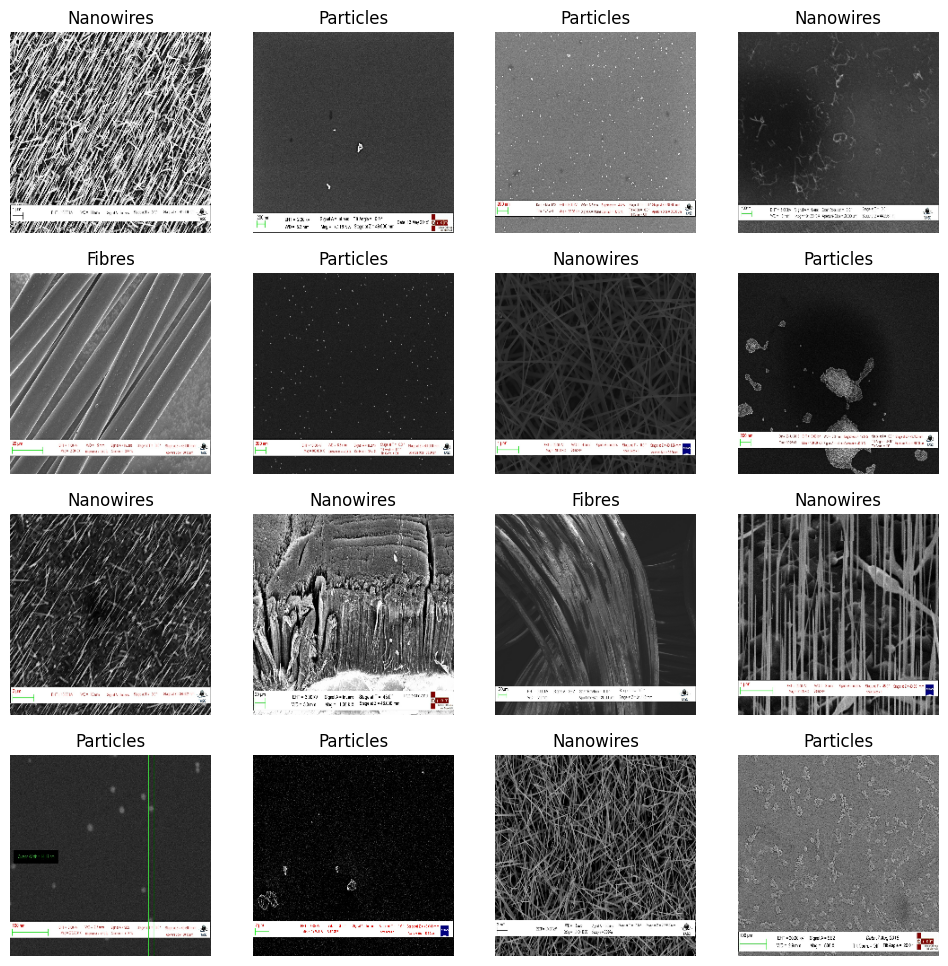

In [13]:
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(2):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")
    

# Data Augmentation

* Resimlerin aşağısında bulunan beyaz kısımlar kesiliyor. 

In [14]:
augment_layers = keras.Sequential([
    Cropping2D(cropping=((0,100),(0,0)))
])
def augment_layer(image,label):
    return augment_layers(image,training = True), label

# Resize and Rescale

In [15]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
])
def resize_rescale_layer(image,label):
    return resize_rescale_layers(image,training = True), label

In [16]:
def resize_rescale(image, label):
  return tf.image.resize(image, (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"])), label

# Dataset Preparation

In [17]:
train_dataset = (train_dataset.map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE).map(resize_rescale_layer,num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE))
validation_dataset = (validation_dataset.prefetch(tf.data.AUTOTUNE))


In [18]:
'''
plt.figure(figsize=(12,12))

for images,labels in train_dataset.take(4):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

    
'''


'\nplt.figure(figsize=(12,12))\n\nfor images,labels in train_dataset.take(4):\n    for i in range(16):\n        ax = plt.subplot(4,4,i+1)\n        plt.imshow(images[i]/255)\n        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])\n        plt.axis("off")\n\n    \n'

In [19]:
'''
plt.figure(figsize=(12,12))

for images,labels in validation_dataset.take(4):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255)
        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")
    
'''



'\nplt.figure(figsize=(12,12))\n\nfor images,labels in validation_dataset.take(4):\n    for i in range(16):\n        ax = plt.subplot(4,4,i+1)\n        plt.imshow(images[i]/255)\n        plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])\n        plt.axis("off")\n    \n'

In [20]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [21]:
validation_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

# MODELING

## Main Model

In [22]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ), #giriş katmanı 3 kanaldan oluşacak gelecek şekli belli değil
    
    resize_rescale_layers, 
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

# Callbacks

In [ ]:
checkpoint = ModelCheckpoint("fine_tuned_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:

early_stopping = EarlyStopping(
    monitor = "val_loss",
    min_delta=0,
    patience =6,
    verbose=0,
    mode = "auto",
    baseline = None,
    restore_best_weights = False
)

In [ ]:

plateau_callback = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.1,
    patience = 2,
    verbose =1
)

In [ ]:

csv_callback = CSVLogger(
    "logs.csv",separator =",",append = False
)

## Metrics

In [ ]:
metrics = [
    Accuracy(name="accuracy"),
    TruePositives(name="tp"),
    FalsePositives(name="fp"),
    TrueNegatives(name="tn"),
    FalseNegatives(name = "fn"),
    Precision(name = "precision"),
    Recall(name= "recall"),
    AUC(name = "auc"),

]

# Transfer Learning

### EfficentNetB0 - 224x224

In [23]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

def build_efficentB0(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### EfficentNetB3 300*300

In [ ]:
def build_efficentB3(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### EfficentNetB7 600x600

In [24]:
# https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

def build_efficentB7(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)

    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### Resnet50 224x224

In [25]:
def build_resnet50(num_classes):
    inputs = Input(shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3))
    model = model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.2

    x = Dropout(top_dropout_rate,name = "top_dropout")(x)
    outputs = Dense(num_classes,activation="softmax",name = "pred")(x)

    model = Model(inputs,outputs,name = "EfficentNet")

    optimizer = Adam(learning_rate=0.00001)

    model.compile(
        optimizer=optimizer, loss = "categorical_crossentropy", metrics=["accuracy"]
    )
    return model

### Freezing Layers

In [26]:
def unfreeze_model(model, start_layer, end_layer):
    for layer in model.layers[start_layer:end_layer]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])





# Model Training

In [ ]:
model = build_efficentB0(CONFIGURATION["NUM_CLASSES"])

In [ ]:
unfreeze_model(model,-10,None)

In [ ]:
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=10,callbacks = WandbCallback(),checkpoint,early_stopping)

## Model Save

In [ ]:
model.save("efficent_net_efficent224.h5")
model.save("efficent_net_efficent224.keras")

In [ ]:
model.evaluate(test_dataset)

## After MODEL

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in test_dataset:
      predicted.append(model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
    
    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])
        
    wandb.log({"conf_mat": cm})

In [ ]:
class LogResultsTable(Callback):
  def on_epoch_end(self, epoch, logs):
    
    columns=["image", "Predicted", "Label"]
    
    val_table = wandb.Table(columns = columns)

    
    for im, label in validation_dataset.take(25):

      pred = CONFIGURATION["CLASS_NAMES"][tf.argmax(model(im), axis = -1).numpy()[0]]
      label = CONFIGURATION["CLASS_NAMES"][tf.argmax(label, axis = -1).numpy()[0]]

      row = [wandb.Image(im), pred, label]
      
      val_table.add_data(*row)

      
    wandb.log({"Model Results" : val_table})
